In [297]:
## Import necessary libraries here (You can add libraries you want to use here)
import cv2
import numpy as np
from scipy.io import loadmat
from scipy import ndimage
import matplotlib.pyplot as plt
import os, sys, time
%matplotlib inline

# Part 1: A Feature Tracker (50 Points)

## Overview

In the problem, you will implement a corner detector and feature tracker that track features from the image sequence hotel. Since this is a two part problem, we have included precomputed intermediate results in the *Data* section in case you’re unable to complete any portion.

<img src="https://drive.google.com/uc?id=1sBtKpU2mYEPZ9c2Cvw-DBuLBPK2gYwC-" width="700"/>

**Note:**  Do not use existing keypoint
detectors, trackers, or structure from motion code, such as found on the web, and OpenCV.

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [298]:
# Download Data -- run this cell only one time per runtime
# !gdown 1fT0H-FbbDZnjMfCJHZcscpcwAXHhGgNw
# !unzip "/content/part1_images.zip" -d "/content/"
# !gdown 1r-Pdino6MRLCEWX_sQOgd8D5AVsRc7Ym
# Load Initial Key Points
data = loadmat('initial_keypoints.mat')
X0 = data['Xo']
Y0 = data['Yo']

## Helper Functions

In [299]:
def readImages(folder, num_images):
  arr_images = []
  for i in range(num_images):
    arr_images.append(cv2.imread(f'{folder}hotel.seq{i}.png'))
  return np.array(arr_images, dtype=np.float32)

def normalize(image):
    """
    normalize an image so it wouldn't overflow
    """
    return (image - np.min(image)) / np.max((image - np.min(image))) 


# read all 51 sequences of images
folder = 'part1_images/'
im = readImages(folder, 51)

## 1.1 Keypoint Selection (15 pts)

For the first frame, use the second moment matrix to locate strong corners to use as keypoints.
These points will be tracked throughout the sequence in the second part of the problem. Choose a proper threshold so that edges and noisy patches are ignored. Do local non-maxima suppression over a 5x5 window centered at each point.
This should give several hundred good points to track.

### Code (5 pts)

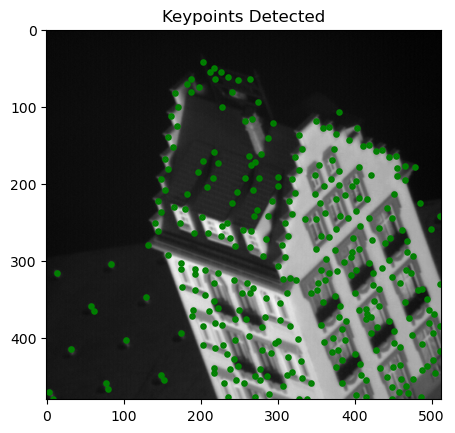

In [300]:
def getKeypoints(img, tau):
  '''
  Detecting keypoints using Harris corner criterion

  Parameters:
    img: input image
    tau: threshold

  Steps:
  1. Convert to grayscale
  2. Smooth image
  3. Compute image gradients
  4. Create structure tensor M
  5. Compute corner response f
  6. Non-maximum suppression
      - Hint: might need to use ndimage.maximum_filter and .nonzero() along the way

  Output:
    keypoints : (N,2) array of [x,y] keypoints
  '''
  window_size = 7

  # Steps 1-5
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.GaussianBlur(img, (5,5), 0)

  # Compute image gradients
  x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)

  # plt.imshow(normalize(x), cmap='gray')
  # plt.title('x gradient')
  # plt.show()

  y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

  # plt.imshow(normalize(y), cmap='gray')
  # plt.title('y gradient')
  # plt.show()


  # Create structure tensor M
  xx = x**2
  xy = x*y
  yy = y**2

  Sxx = cv2.GaussianBlur(ndimage.gaussian_filter(xx, sigma=3), (3,3), 3)
  Sxy = cv2.GaussianBlur(ndimage.gaussian_filter(xy, sigma=3), (3,3), 3)
  Syy = cv2.GaussianBlur(ndimage.gaussian_filter(yy, sigma=3), (3,3), 3)
  
  #Compute corner response f
  detM = (Sxx * Syy) - (Sxy**2)
  traceM = Sxx + Syy
  responses = detM - 0.1* (traceM**2)  # Harris corner measure

  # plt.imshow(responses, cmap='gray')
  # plt.title('y gradient')
  # plt.show()

  # Step 6: Non-maximum suppression
  max_filter = ndimage.maximum_filter(responses, size=5)
  keypoints = np.array((responses == max_filter) & (responses > tau)).nonzero()

  keypoints = np.array(keypoints).T

  return keypoints, responses

# compute keypoints in the first sequence
tau = 100
key_pts, responses = getKeypoints(im[0], tau)

# add plots for the write-up
plt.imshow(normalize(im[0]), cmap='gray')
plt.scatter(key_pts[:, 1], key_pts[:, 0], color='g', s=3, linewidths=3)
plt.title('Keypoints Detected')
plt.show()

### Write-up (10 pts)


*   (5 pts) Explain your implementation of getKeypoints()

* #### First, I convert the image into grey and applied by Guassian filter. Then I calculated x and y ingradients by cv2.sobel. Then I created Create structure tensor M by x^2, y^2 and xy and calculate the determinate, trace, and response (tunning alpha). Finally I applied Non-maximum suppression by 2 cretirias: if the point is the local maxima and the response is greater than tau. I kept the points that qualified and return them as key points.
*   (5 pts) Display the first frame of the sequence overlaid with the detected keypoints. Ensure that they are clearly visible (plot with `color='g' and linewidths=3`)

* #### As above



**Include your write-up here**

## 1.2 Feature Tracking (35 pts)

Apply the Kanade-Lucas-Tomasi tracking procedure to track the keypoints found in part 1.1 (or the given keypoints in the *Data* section) throughout the hotel sequence.

<img src="https://drive.google.com/uc?id=1dU4p4YcnXoQFnrNvleEty_4tDECkVW9Q" width="500"/>

Some keypoints will move out of the image frame over the course of the sequence. Discard keypoints for which the predicted translation falls outside the image frame.

**Hint:**

*  From the 1st frame to the 2nd frame, use the detected keypoints at the first frame as initialization points. From the 2nd to 3rd frame, use the tracked positions at the 2nd frame as initialization. Note that the tracked keypoints in general are not at integer positions.

*  For each point, use a window size of 15 x 15.

Add code to **plot** your tracked points overlayed in the **first sequence** and the **last sequence**. They should look similar to the second picture shown in the Overview section.



### Code (10 pts)

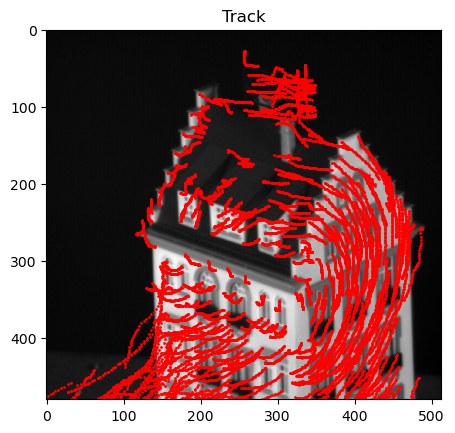

In [301]:
def lucas_kanade_tracking(I1, I2, x, y, ws=5, max_iter=10, epsilon=0.01):
  '''
  Tracking using Lucas-Kanade algorithm

  Parameters:
    I1: first frame of input image sequence (grayscale)
    I2: second frame of input image sequence (grayscale)
    x: x locations of the keypoints in first frame
    y: y locations of the keypoints in first frame
    ws: local window size
    max_iter: number of iterations
    epsilon: threshold for checking convergence

  Steps:
  1. Compute image gradients
  2. Iterate until convergence
      3. Extract image gradients within local window
      4. Construct the second moment matrix A and vector b using results from (3)
      5. Solve for optical flow (u, v) using least squares
      6. Based on the (u, v) obtained in step 5, use bilinear interpolation to get sub-pixel level image gradients then solve the least square again
      7. Update keypoint locations by adding the calculated optical flow vector components
      8. Check convergence

  Output:
    new_x: newly calculated keypoints for second frame
    new_y: newly calculated keypoints for second frame
  '''


  new_x, new_y = x.copy().astype('float32'), y.copy().astype('float32')


  I1 = cv2.GaussianBlur(I1, (5, 5), 0)
  I2 = cv2.GaussianBlur(I2, (5, 5), 0)

  # Compute image gradients
  Ix = cv2.Sobel(I1, cv2.CV_32F, 1, 0, ksize=3)
  Iy = cv2.Sobel(I1, cv2.CV_32F, 0, 1, ksize=3)
  It = I2 - I1

  
  # Iterate until convergence
  for point in range(len(x)):
    for iteration in range(max_iter):
      u, v = 0, 0
      # local window 
      # x_min, x_max = int(new_x[point] - half_ws),int(new_x[point] + half_ws)
      # y_min, y_max = int(new_y[point] - half_ws), int(new_y[point] + half_ws)
      # print(new_x[point],new_y[point])
      center = (new_x[point], new_y[point])
      Ix_local = cv2.getRectSubPix(Ix,(ws,ws),center)
      Iy_local = cv2.getRectSubPix(Iy,(ws,ws),center)
      It_local = cv2.getRectSubPix(It,(ws,ws),center)

      
      # Extract image gradients within local window
      # Ix_local = Ix[y_min:y_max+1, x_min:x_max+1]
      # Iy_local = Iy[y_min:y_max+1, x_min:x_max+1]
      # It_local = It[y_min:y_max+1, x_min:x_max+1]
      # Construct the second moment matrix A and vector b using results from (3)
      A = np.vstack((Ix_local.ravel(), Iy_local.ravel())).T
      b = -It_local.ravel()

      # Solve for optical flow (u, v) using least squares
      nuv= np.linalg.lstsq(A, b, rcond=None)[0]
      u, v = nuv if nuv.size else (0, 0)
      

      # Update keypoint locations by adding the calculated optical flow vector components
      new_x[point] += u
      new_y[point] += v

      # Check convergence
      # print(iteration)
      # print(u)
      # print(v)
      # print(np.linalg.norm([u, v]))
      if np.linalg.norm([u, v]) < epsilon:
        
        break
    
  return new_x, new_y


# track keypoints across between 2 frames in the image sequence
# x , y = [],[]
# for i in range(1,len(im)-1):
#   image1 = im[i-1]
#   image2 = im[i]
#   key_pts, responses = getKeypoints(img=image1, tau=100)
#   x_initial, y_initial = key_pts[:, 1], key_pts[:, 0]
#   new_x, new_y = lucas_kanade_tracking(image1, image2, x_initial, y_initial)
#   x.append(new_x)
#   y.append(new_y)

# x_flat = np.concatenate(x)
# y_flat = np.concatenate(y)

# plt.imshow(normalize(image1), cmap='gray')
# plt.scatter(x_flat, y_flat, color='r', s=1, linewidths=1)
# plt.title('Track')
# plt.show()

x,y = [],[]

key_pts, responses = getKeypoints(img=image1, tau=100)
x_initial, y_initial = key_pts[:, 1], key_pts[:, 0]

x.append(x_initial.astype('int'))
y.append(y_initial.astype('int'))
for i in range(1,len(im)-1):
  image1 = im[i-1]
  image2 = im[i]

  x_initial, y_initial = lucas_kanade_tracking(image1, image2, x_initial, y_initial ,ws=15,max_iter=10)
  filtered_x = []
  filtered_y = []
  for i in range(len(x_initial)):
    if 0 < x_initial[i] < image1.shape[1] and 0 < y_initial[i] < image1.shape[0]:
      filtered_x.append(int(x_initial[i]))
      filtered_y.append(int(y_initial[i]))
  x.append(filtered_x)
  y.append(filtered_y)

x_flat = np.concatenate(x)
y_flat = np.concatenate(y)

plt.imshow(normalize(image1), cmap='gray')
plt.scatter(x_flat.astype('int'), y_flat.astype('int'), color='r', s=1, linewidths=1)
plt.title('Track')
plt.show()

### Write-up (25 pts)

*   (5 pts) For all the keypoints, display (1) the keypoints at the first frame (as green) and (2) the tracked keypoints at the second frame (as red) on the first frame of the sequence.
*   (10 pts) For 20 random keypoints, draw the 2D path over the sequence of frames. That is, plot the progression of image coordinates for each of the 20 keypoints across all 50 images. Plot each of the paths on the same figure, overlaid on the first frame of the sequence.
*   (10 pts) On top of the first frame, plot the points which have moved out of frame at some point along the sequence. **Hint**: you may want to implement a boolean mask to keep track of which detected corners moved out of frame.





**Include your write-up here**



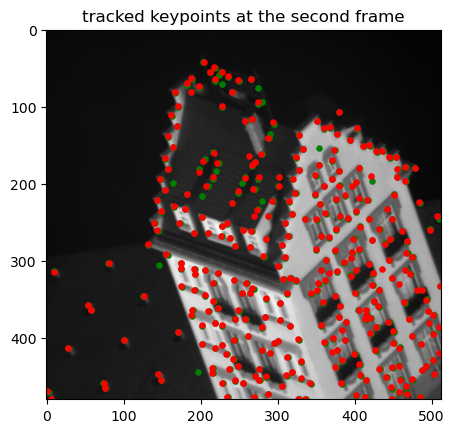

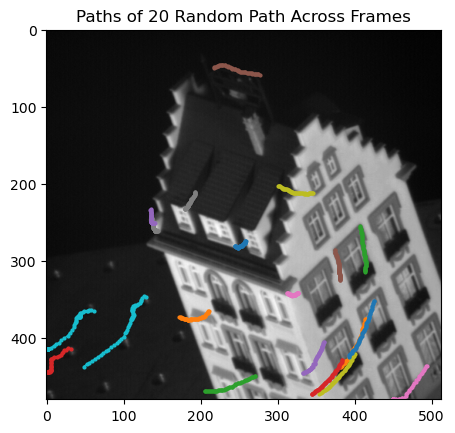

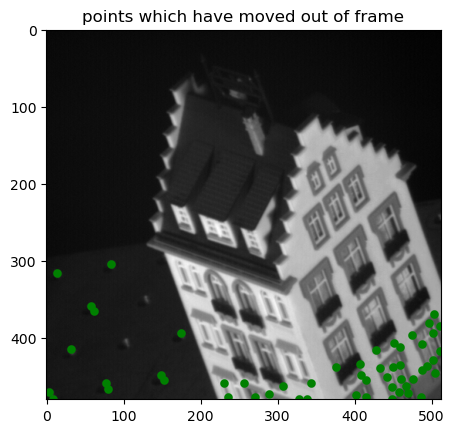

In [302]:
''' display (1) the keypoints at the first frame (as green) and (2) the tracked keypoints at the second frame (as red) on the first frame of the sequence.'''
image1 = im[0]
image2 = im[1]
key_pts, responses = getKeypoints(img=image1, tau=100)
x_initial, y_initial = key_pts[:, 1], key_pts[:, 0]
new_x, new_y = lucas_kanade_tracking(image1, image2, x_initial, y_initial,ws=15,max_iter=10)

key_pts, responses = getKeypoints(img=image2, tau=100)
x_initial, y_initial = key_pts[:, 1], key_pts[:, 0]

plt.imshow(normalize(image1), cmap='gray')
plt.scatter(x_initial, y_initial, color='g', s=3, linewidths=3)
plt.scatter(new_x.astype('int'), new_y.astype('int'), color='r', s=3, linewidths=3)
plt.title('tracked keypoints at the second frame')
plt.show()
''' For 20 random keypoints, draw the 2D path over the sequence of frames.'''

image1 = im[0]
key_pts, _ = getKeypoints(img=image1, tau=100)
x_initial, y_initial = key_pts[:, 1], key_pts[:, 0]

# Select 20 random keypoints if more than 20 keypoints are detected
num_keypoints = len(x_initial)

indices = np.random.choice(num_keypoints, 20, replace=False)
x_initial = x_initial[indices]
y_initial = y_initial[indices]

# Initialize paths for selected keypoints
paths = [[(int(x),int(y))] for x, y in zip(x_initial, y_initial)]

for i in range(1, len(im)):
  image1, image2 = im[i-1], im[i]
  x_initial, y_initial = lucas_kanade_tracking(image1, image2, x_initial, y_initial, ws=15, max_iter=10)

  for path_idx, (x, y) in enumerate(zip(x_initial, y_initial)):
    if 0 <= x < image2.shape[1] and 0 <= y < image2.shape[0]:
      paths[path_idx].append((int(x), int(y)))
    else:
      paths[path_idx].append(paths[path_idx][-1]) 
            

plt.imshow(normalize(im[0]), cmap='gray')
# Plot each path
for path in paths:
  x_values, y_values = zip(*path)
  plt.plot(x_values, y_values, '-o', markersize=2, linewidth=1)

plt.title('Paths of 20 Random Path Across Frames')
plt.show()


'''plot the points which have moved out of frame at some point along the sequence''' 
image1 = im[0]
key_pts, _ = getKeypoints(img=image1, tau=100)
x_initial, y_initial = key_pts[:, 1], key_pts[:, 0]
out_of_frame_dist = {}
for i in range(len(x_initial)):
  out_of_frame_dist[(x_initial[i],y_initial[i])] = False

num_keypoints = len(x_initial)
# Initialize paths for selected keypoints
paths = [[(int(x),int(y))] for x, y in zip(x_initial, y_initial)]

for i in range(1, len(im)):
  image1, image2 = im[i-1], im[i]
  x_initial, y_initial = lucas_kanade_tracking(image1, image2, x_initial, y_initial, ws=15, max_iter=10)

  for path_idx, (x, y) in enumerate(zip(x_initial, y_initial)):
    
    if 0 <= x < image1.shape[1] and 0 <= y < image1.shape[0]:
      paths[path_idx].append((int(x), int(y)))
    else:
      
      out_of_frame_dist[paths[path_idx][0]] = True
      
      paths[path_idx].append(paths[path_idx][-1]) 


x_list = []
y_list = []
for key in out_of_frame_dist:
  if out_of_frame_dist[key]:
    x, y = key
    x_list.append(x)
    y_list.append(y)

plt.imshow(normalize(im[0]), cmap='gray')
plt.scatter(x_list, y_list, color='g', s=10, linewidths=3)
plt.title('points which have moved out of frame')
plt.show()